In [1]:
import pandas as pd
import numpy as np

In [2]:
ladata = pd.read_csv('data/la_clean.csv')

In [3]:
ladata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980497 entries, 0 to 980496
Data columns (total 14 columns):
Unnamed: 0                      980497 non-null int64
CITY                            980497 non-null object
LATITUDE                        980497 non-null float64
LONGITUDE                       980497 non-null float64
STATION_NAME                    980497 non-null object
STATISTICAL_CODE_DESCRIPTION    980497 non-null object
STREET                          980497 non-null object
ZIP                             980497 non-null float64
CrimeCat                        980497 non-null int64
Hour                            980497 non-null int64
Month                           980497 non-null int64
Day                             980497 non-null int64
Year                            980497 non-null int64
DayOfWeek                       980497 non-null int64
dtypes: float64(3), int64(7), object(4)
memory usage: 104.7+ MB


In [4]:
ladf = ladata.groupby(['Year', 'Month', 'ZIP', 'CrimeCat'])['Unnamed: 0'].count()

In [5]:
ladf = ladf.unstack().reset_index()

In [6]:
ladf = ladf.fillna(0)

In [7]:
ladf.head()

CrimeCat,Year,Month,ZIP,1,2,3,4,5,6,7,8,9,10
0,2004,1,90001.0,0.0,1.0,1.0,5.0,8.0,0.0,5.0,0.0,4.0,0.0
1,2004,1,90002.0,3.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0
2,2004,1,90004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2004,1,90005.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004,1,90006.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X = ladf.drop(['Year', 'Month', 'ZIP'], axis=1).values

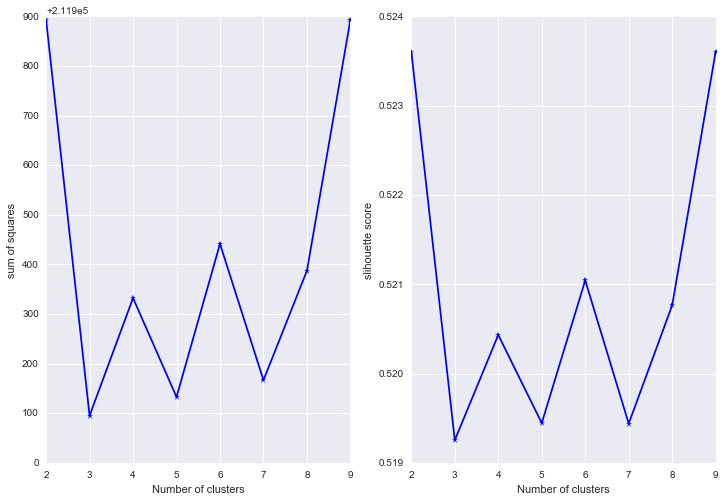

In [9]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
%matplotlib inline

scaler = StandardScaler()
X_trans = scaler.fit_transform(X)
def kmeans_all(X):
    dists = []
    scores = []
    for k in xrange(2, 10):
#         print k
        kmeanModel = KMeans()
        kmeanModel.fit(X)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        dist = cdist(X, centroids)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 10), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 10), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()
kmeans_all(X)


NMF done!


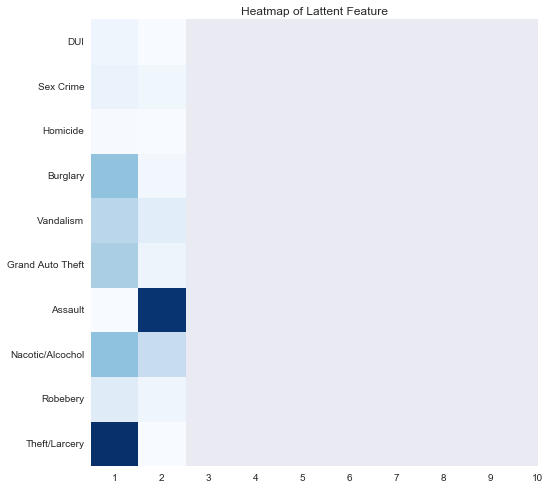

NMF done!


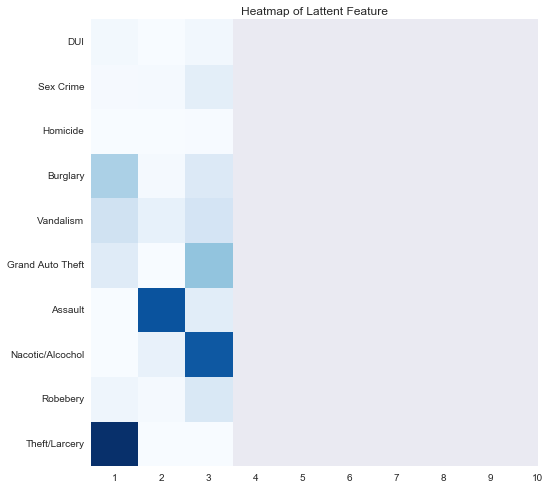

NMF done!


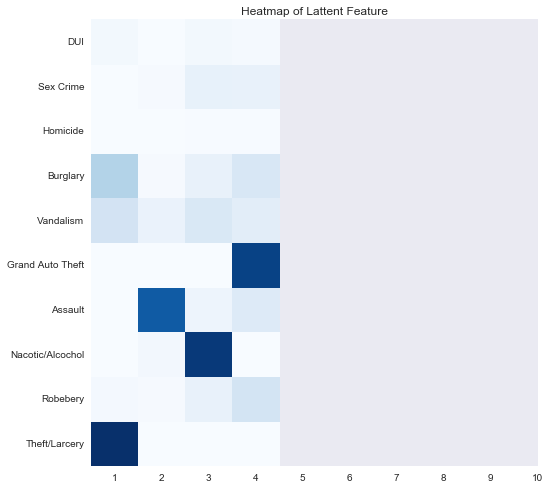

NMF done!


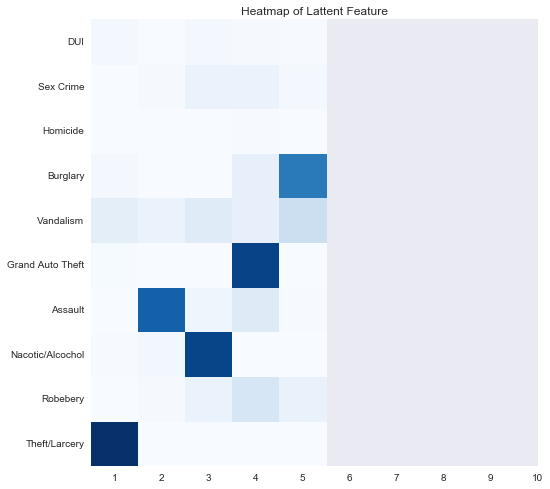

NMF done!


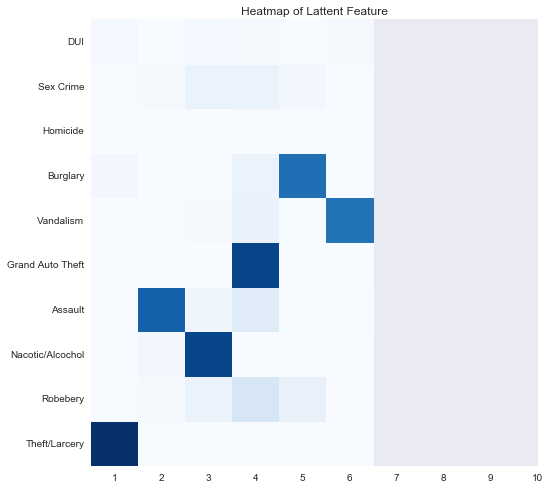

NMF done!


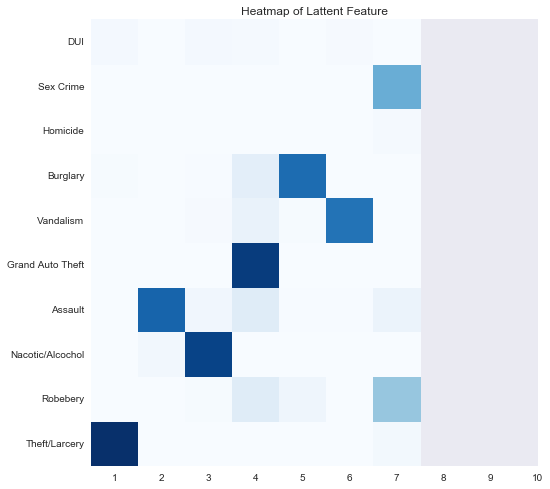

NMF done!


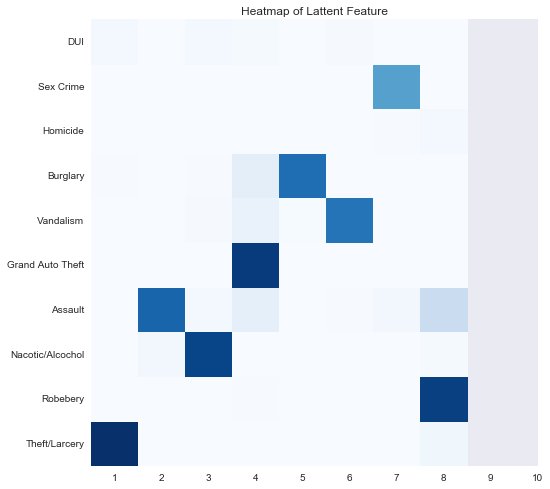

NMF done!


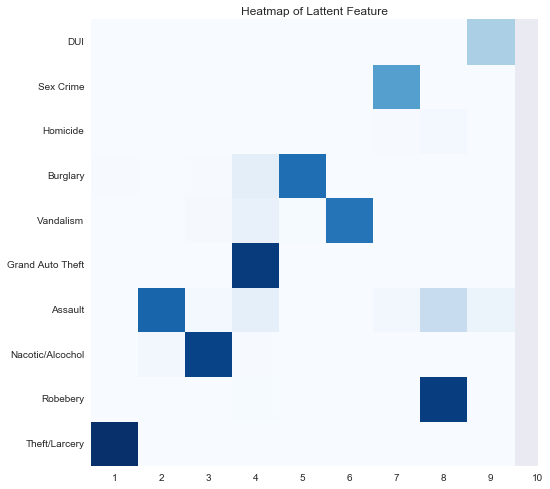

NMF done!


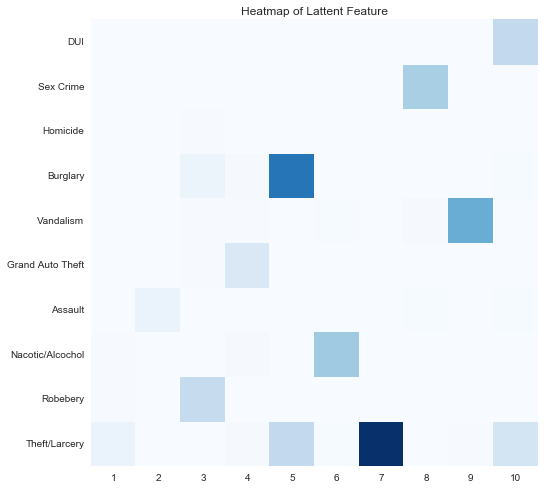

In [10]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary', 8: 'Homicide', 9: 'Sex Crime', 10: 'DUI'}

def build_nmf_all(X,k):
    nmfModel = NMF(n_components=k)
    W = nmfModel.fit_transform(X)
    H = nmfModel.components_
    print 'NMF done!'
    plot_heatmap(H.T)
    return W, H
    

def plot_heatmap(data):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(10)+0.5, minor=False, )
    ax.set_yticks(np.arange(10)+0.5, minor=False)

    # want a more natural, table-like display
#     ax.invert_yaxis()
#     ax.xaxis.tick_top()
    ax.set_xticklabels(range(1,11), minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def try_different_k_class(X):
    for k in xrange(2, 11):
        build_nmf_all(X, k)

try_different_k_class(X)

0.00401338898046
0.00303635261266
0.0024242274903
0.00211870715119
0.00256851390117
0.00154261693379
0.0018793923448
0.00223861291776
0.00188221183583
0.00199360230597


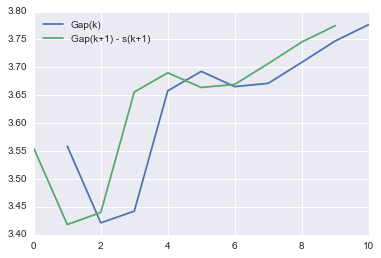

In [35]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample


# returns series of random values sampled between min and max values of passed col
def get_ref(shape, tops, bots): 
    dists = tops - bots
    ref = np.random.random(shape) * dists + bots
    return ref

def iter_kmeans(refs, k):
    vals = []
    for ref in refs:
        model = KMeans(n_clusters=k, n_init=3)
        model.fit(ref)
        vals.append(np.log(model.inertia_))
    return np.array(vals)

def gap_statistic(X, max_k=10, B=10):
    gaps = []
    gaps_minus = []
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    refs = [get_ref(X.shape, tops, bots) for i in xrange(B)]
#     print refs
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(X)
        ref_log_inertias = iter_kmeans(refs, k)       
        sdk = np.std(ref_log_inertias)
#         print sdk
        gap = ref_log_inertias.mean() - np.log(km_act.inertia_)
        sk = np.sqrt(1 + 1.0/B) * sdk
        print sk
#         print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps.append(gap)
        gaps_minus.append(gap - sk)
    plt.figure()
    plt.plot(range(1, max_k+1), gaps, label='Gap(k)')
    plt.plot(range(max_k), gaps_minus, label='Gap(k+1) - s(k+1)')
    plt.legend(loc='best')
    plt.show()
    return gaps
gaps = gap_statistic(X)